In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [2]:
train_df = pd.read_csv('./Dataset/training_data_v10.csv', encoding="latin1")
test_df = pd.read_csv('./Dataset/test_data_v10.csv', encoding="latin1")

In [3]:
# Preparar X e y
# Se houver colunas que não são features (ex: datas), remove-as aqui
cols_to_drop = ['AVERAGE_SPEED_DIFF', 'record_date', 'city_name']
X = train_df.drop(columns=[c for c in cols_to_drop if c in train_df.columns])
y = train_df['AVERAGE_SPEED_DIFF']

# Preparar dados de submissão (garantir mesmas colunas)
X_submission = test_df.drop(columns=[c for c in cols_to_drop if c in test_df.columns])
X_submission = X_submission[X.columns]

In [4]:
# Divisão dos dados: 25% para teste, utilizando semente 2023 e estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=2023, 
    stratify=y
)

# ==============================================================================
# TAREFA 2: Modelação com GridSearchCV (Decision Tree)
# ==============================================================================
# Diferente de modelos como SVM ou MLP, a Decision Tree não exige obrigatoriamente a normalização dos dados.
dt = DecisionTreeClassifier(random_state=2023)

# Definição do grid de hiperparâmetros para otimização
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("A iniciar GridSearchCV para Decision Tree...")
grid_searchDT = GridSearchCV(dt, param_grid, cv=5, refit=True, verbose=2, n_jobs=-1)
grid_searchDT.fit(X_train, y_train)

# Seleção do melhor estimador encontrado pelo Grid Search
dt_best = grid_searchDT.best_estimator_
print("\nMelhor estimador:", dt_best)

A iniciar GridSearchCV para Decision Tree...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Melhor estimador: DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=2023)



Validation Accuracy: 0.7457
------------------------------
Classification Report:

              precision    recall  f1-score   support

        None       0.85      0.90      0.88       550
         Low       0.65      0.63      0.64       355
      Medium       0.70      0.68      0.69       413
        High       0.67      0.68      0.68       265
   Very_High       0.83      0.75      0.79       120

    accuracy                           0.75      1703
   macro avg       0.74      0.73      0.73      1703
weighted avg       0.74      0.75      0.74      1703



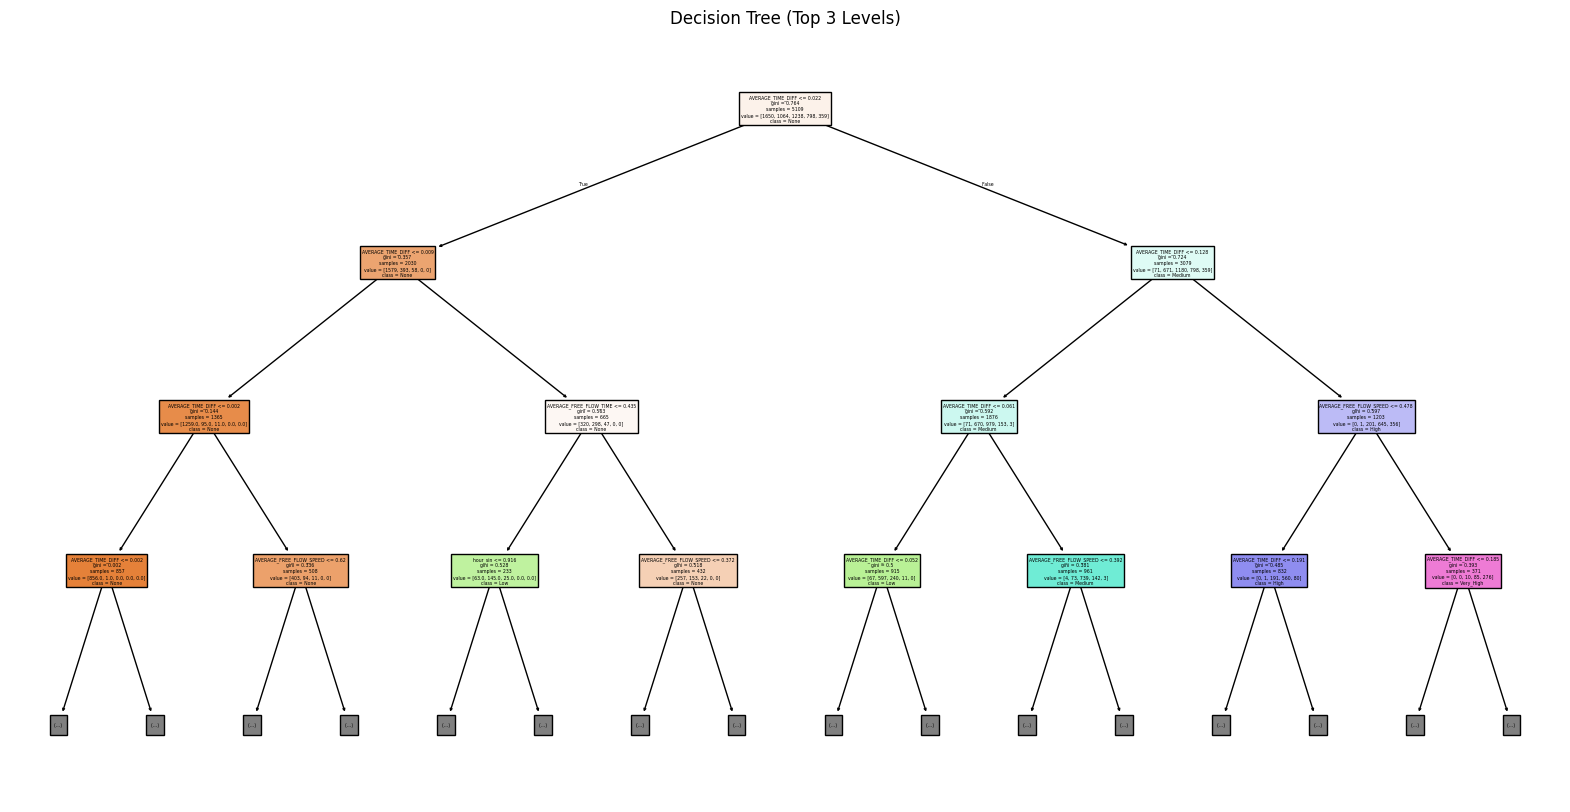

In [5]:
grid_predictionDT = dt_best.predict(X_test)

print("\nValidation Accuracy: {:.4f}".format(accuracy_score(y_test, grid_predictionDT)))
print("-" * 30)
print("Classification Report:\n")
target_names = ['None', 'Low', 'Medium', 'High', 'Very_High']
print(classification_report(y_test, grid_predictionDT, target_names=target_names))

# Visualização gráfica da estrutura da árvore gerada

plt.figure(figsize=(20,10))
plot_tree(dt_best, feature_names=X.columns, class_names=target_names, filled=True, max_depth=3)
plt.title("Decision Tree (Top 3 Levels)")
plt.show()

In [6]:
print("\nA gerar previsões para submissão...")

# Previsão direta nos dados originais de submissão sem normalização
predictionDT = dt_best.predict(X_submission)

# Reversão do mapeamento numérico para categorias de texto
target_map_reverse = {
    0: 'None', 
    1: 'Low', 
    2: 'Medium', 
    3: 'High', 
    4: 'Very_High'
}

prediction_text = [target_map_reverse.get(p, 'None') for p in predictionDT]

submission = pd.DataFrame({
    'RowId': range(1, len(prediction_text) + 1),
    'Speed_Diff': prediction_text
})

submission.to_csv('submission_dt_task2_style.csv', index=False)
print("Ficheiro criado: submission_dt_task2_style.csv")
print(submission.head())


A gerar previsões para submissão...
Ficheiro criado: submission_dt_task2_style.csv
   RowId Speed_Diff
0      1       None
1      2        Low
2      3       None
3      4       High
4      5        Low
